In [375]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import copy
import yfinance as yf
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [376]:
"""Testing for a GPU"""

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))
x = tf.random.uniform([3, 3])

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


Data Preperation

In [377]:
"""Loading s&p 100 tickers"""



sample_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

data = yf.download(sample_tickers, start="2015-01-01", end="2023-01-01", interval='1d')

close = data['Close']
volume = data['Volume']


[*********************100%***********************]  5 of 5 completed


In [378]:
close.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2015-01-02,24.237553,15.4260,26.278944,39.858452,0.483011
2015-01-05,23.554747,15.1095,25.778225,39.491928,0.474853
2015-01-06,23.556953,14.7645,25.142035,38.912281,0.460456
2015-01-07,23.887276,14.9210,25.068092,39.406677,0.459257
2015-01-08,24.805079,15.0230,25.155432,40.565952,0.476533


In [379]:
close.tail()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2022-12-23,129.900284,85.250000,88.560867,233.155472,15.190793
2022-12-27,128.097488,83.040001,86.734657,231.426819,14.106878
2022-12-28,124.166786,81.820000,85.374939,229.053558,14.021963
2022-12-29,127.683723,84.180000,87.786697,235.382248,14.588395
2022-12-30,127.998978,84.000000,87.568367,234.220032,14.599384


In [380]:
close_np = data['Close'].to_numpy()
volume_np = data['Volume'].to_numpy()

In [381]:
from technical_indicators import AddTechnicalIndicators

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()




/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [382]:
print(data[0])

[24.23755264 15.42599964 26.27894402 39.85845184  0.48301142         nan
         nan         nan         nan         nan 24.23755264 39.85845184
 26.27894402 15.42599964  0.48301142         nan         nan         nan
         nan         nan]


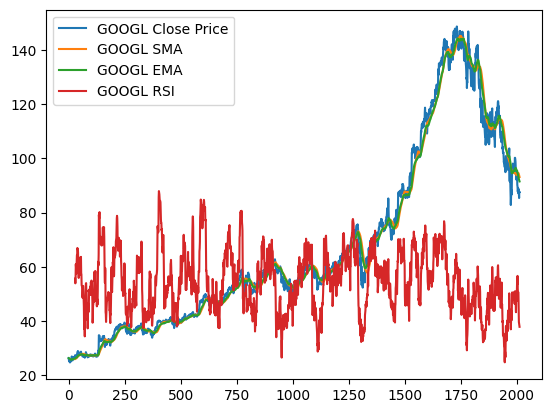

In [383]:
googl = data[:, 2]
googl_sma = data[:, 7]
googl_ema = data[:, 12]
googl_rsi = data[:, 17]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [384]:
print(data.shape)

(2014, 20)


In [385]:
from numpy.lib.stride_tricks import sliding_window_view

def add_look_back(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i])
    return numpy.array(X), numpy.array(y)

In [386]:
lookback = 10
x, y = add_look_back(data, look_back=lookback)
print(x.shape)
print(y.shape)
print(close.shape)


(2004, 10, 20)
(2004, 20)
(2014, 20)


In [ ]:
class RollingZScoreNorm:
    def __init__(self, data, look_back=30):
        self.data = data
    
    def get_rolling_z(self, window=30):
        """Add Rolling Z-Score to the data."""
        """Final Ouput must then me computed as """

        data = self.data
        normalized_data = copy.deepcopy(data)



        for col in self.data.columns:
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            normalized_data[col] = (data[col] - rolling_mean) / rolling_std
        
        return normalized_data
    
    def inverse_transform(self, normalized_output, window=30):
        """normalized_output must be a numpy array"""
        """Inverse transform the normalized data back to original scale."""
        data = self.data
        inv_data = normalized_output.copy()


        for i, col in  enumerate(self.data.columns):
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            inv_data[i] = (normalized_output[i] * rolling_std) + rolling_mean
        return inv_data
    


In [388]:
norm_class = RollingZScoreNorm(data_frame)
norm_data = norm_class.get_rolling_z(window=lookback)


In [389]:
norm_data.to_numpy()[29]

array([ 1.62958807,  1.65705857,  1.9249733 ,  2.01092809,  1.73581632,
               nan,         nan,         nan,         nan,         nan,
        1.67015819, -1.09773767,  1.88900493,  1.43117798,  2.079592  ,
               nan,         nan,         nan,         nan,         nan])

In [390]:

x, y = add_look_back(norm_data.to_numpy(), look_back=lookback)

X = x
Y = y[:, :5]

In [391]:
X =x[59:]
Y =Y[59:]

In [392]:
print(X.shape, Y.shape)

(1945, 10, 20) (1945, 5)


Basic Model

In [393]:
from keras import layers, Sequential

In [394]:
model = keras.Sequential()

model.add(layers.Dense(512, input_shape=(lookback, 20)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.1))

model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(128)) 
model.add(layers.Dropout(0.1))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(5, activation='linear'))


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/home/mb0w3n/project/IndividualProject/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mb0w3n/project/IndividualProject/venv/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [395]:
model.fit(X,Y, epochs=10, batch_size=32)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.9973 - mae: 0.7906
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7359 - mae: 0.6648
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6497 - mae: 0.6216
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6031 - mae: 0.5950
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5521 - mae: 0.5712
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5013 - mae: 0.5440
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4608 - mae: 0.5244
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4172 - mae: 0.4954
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3913 - mae: 0.4833
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3536 - mae: 0.4579


Test and Visuals

In [396]:
preds = model.predict(X)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [397]:
print(preds.shape, Y.shape, X.shape)

(1945, 5) (1945, 5) (1945, 10, 20)


In [398]:
def directional_accuracy(predictions, actuals):
    """
    Evaluate the directional accuracy of predictions against actual values.
    
    This metric calculates the percentage of predictions that correctly 
    identify the direction (positive/negative) of the actual values.
    
    Args:
        predictions (numpy.ndarray): Predicted values
        actuals (numpy.ndarray): Actual/true values
    
    Returns:
        float: Directional accuracy as a percentage (0-100)
    """
    if predictions.shape != actuals.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs actuals {actuals.shape}")
    
    # Check if both predictions and actuals have the same direction
    # (both > 0, both < 0, or both == 0)
    correct_direction = ((actuals > 0) == (predictions > 0)).mean()
    
    return correct_direction * 100  # Return as percentage



In [399]:
def mae(predictions, actuals):

    return np.abs(predictions - actuals).mean()

In [400]:
def plot_predictions_by_asset(predictions, actuals, tickers):
    """
    Generate individual plots for each asset showing predicted vs actual values.
    
    Args:
        predictions (numpy.ndarray): Predicted values with shape (samples, num_assets)
        actuals (numpy.ndarray): Actual values with shape (samples, num_assets)
        tickers (list): List of ticker symbols corresponding to each asset
    """
    num_assets = len(tickers)
    fig, axes = plt.subplots(num_assets, 1, figsize=(12, 3*num_assets))
    
    for i, ticker in enumerate(tickers):
        axes[i].plot(actuals[:, i], label='Actual', linewidth=2, alpha=0.8)
        axes[i].plot(predictions[:, i], label='Predicted', linewidth=2, alpha=0.8)
        axes[i].set_title(f'{ticker} - Predicted vs Actual Values : acc = {directional_accuracy(predictions[:, i], actuals[:, i])}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Normalized Price')
        axes[i].legend(loc='upper left')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [401]:
print(directional_accuracy(preds, Y))
print(mae(preds, Y))

90.35475578406171
0.38469765488477536


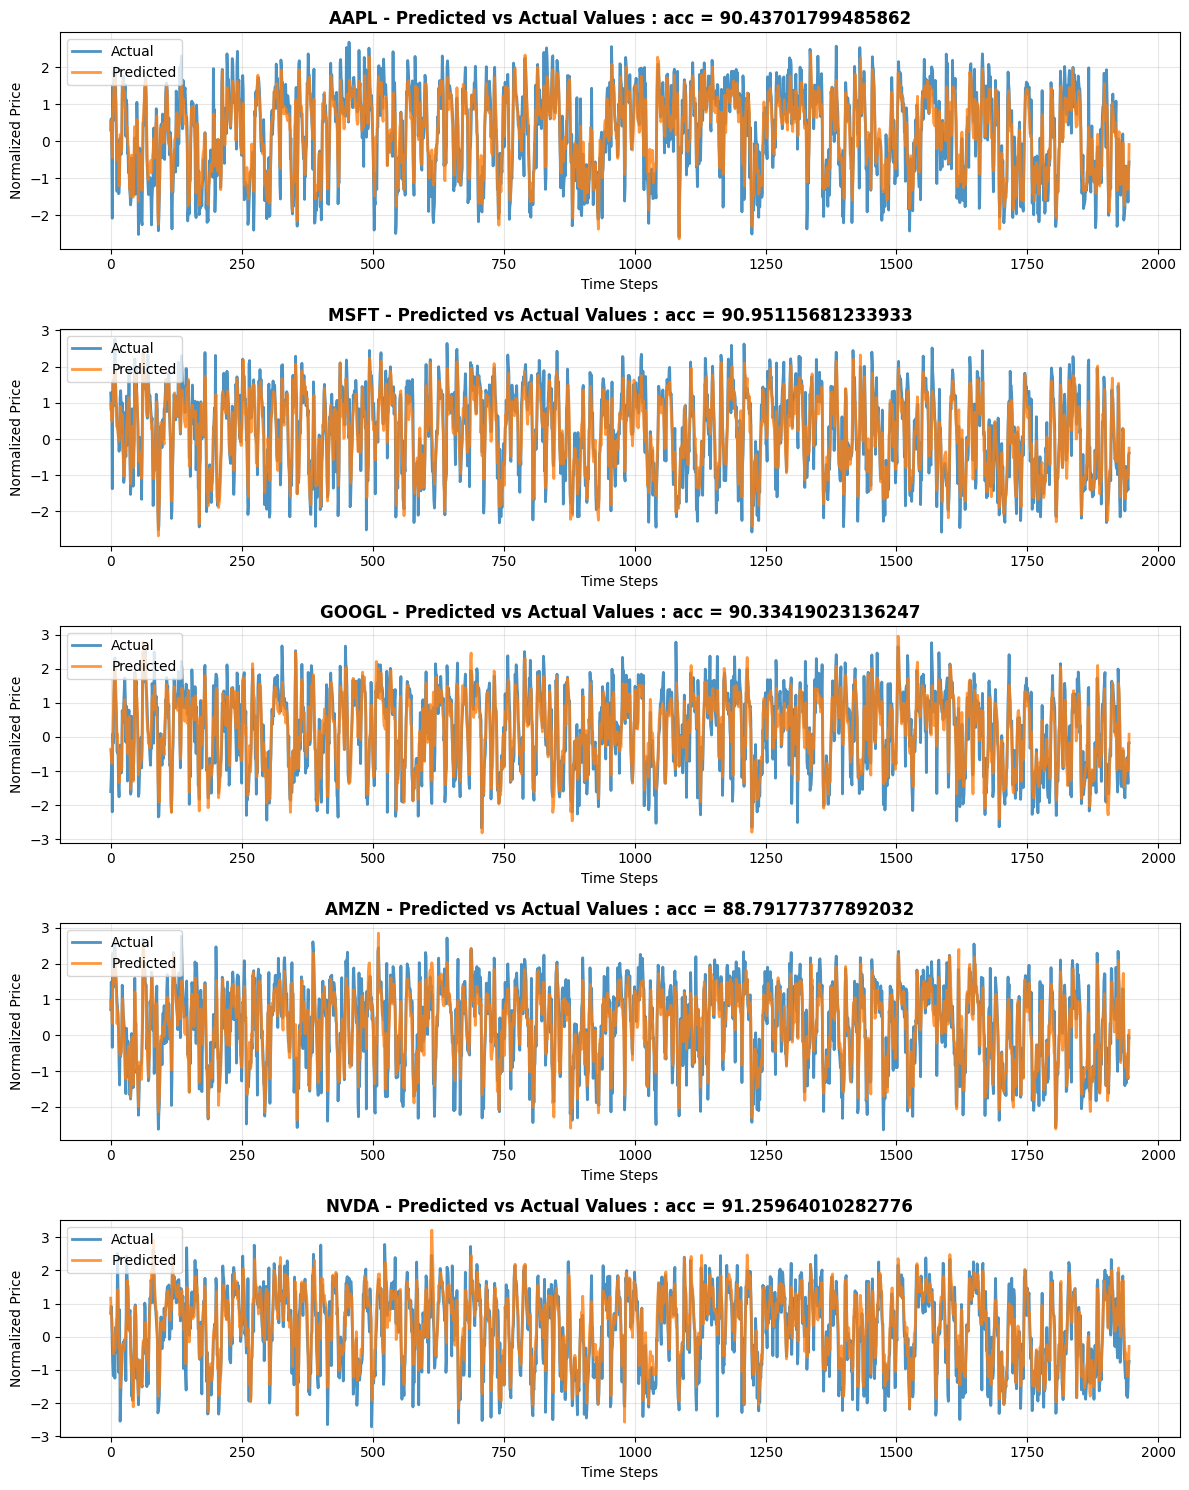

In [402]:
plot_predictions_by_asset(preds, Y, sample_tickers)

Testing And Validation

[*********************100%***********************]  5 of 5 completed
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A v

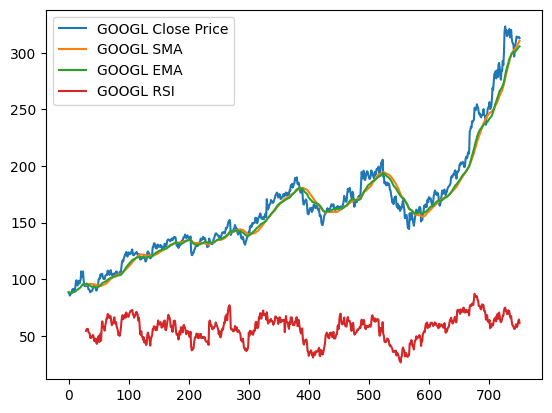

In [403]:
data = yf.download(sample_tickers, start="2023-01-01", end="2026-01-01")
close = data['Close']

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()

googl = data[:, 2]
googl_sma = data[:, 7]
googl_ema = data[:, 12]
googl_rsi = data[:, 17]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [404]:

norm_class = RollingZScoreNorm(data_frame)
norm_data = norm_class.get_rolling_z(window=lookback)

test_x, test_y = add_look_back(norm_data.to_numpy(), look_back=lookback)

test_y =test_y[59:, :5]

test_x = test_x[59:]

print(test_y.shape, test_x.shape)

(683, 5) (683, 10, 20)


In [405]:
test_pred = model.predict(test_x)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


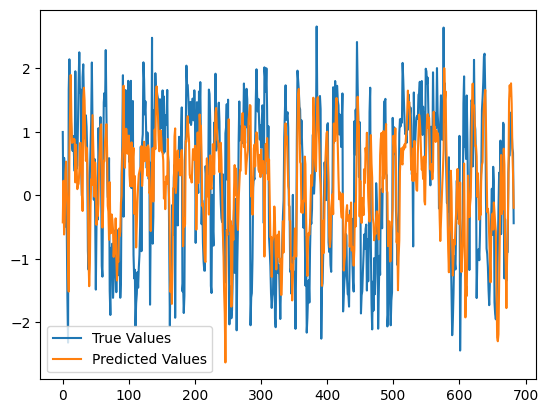

In [406]:
plt.plot(test_y[:, 3], label='True Values')
plt.plot(test_pred[:, 3], label='Predicted Values')
plt.legend()

In [407]:
print(directional_accuracy(test_pred, test_y))
print(mae(test_pred, test_y))

78.12591508052708
0.7454295111792832


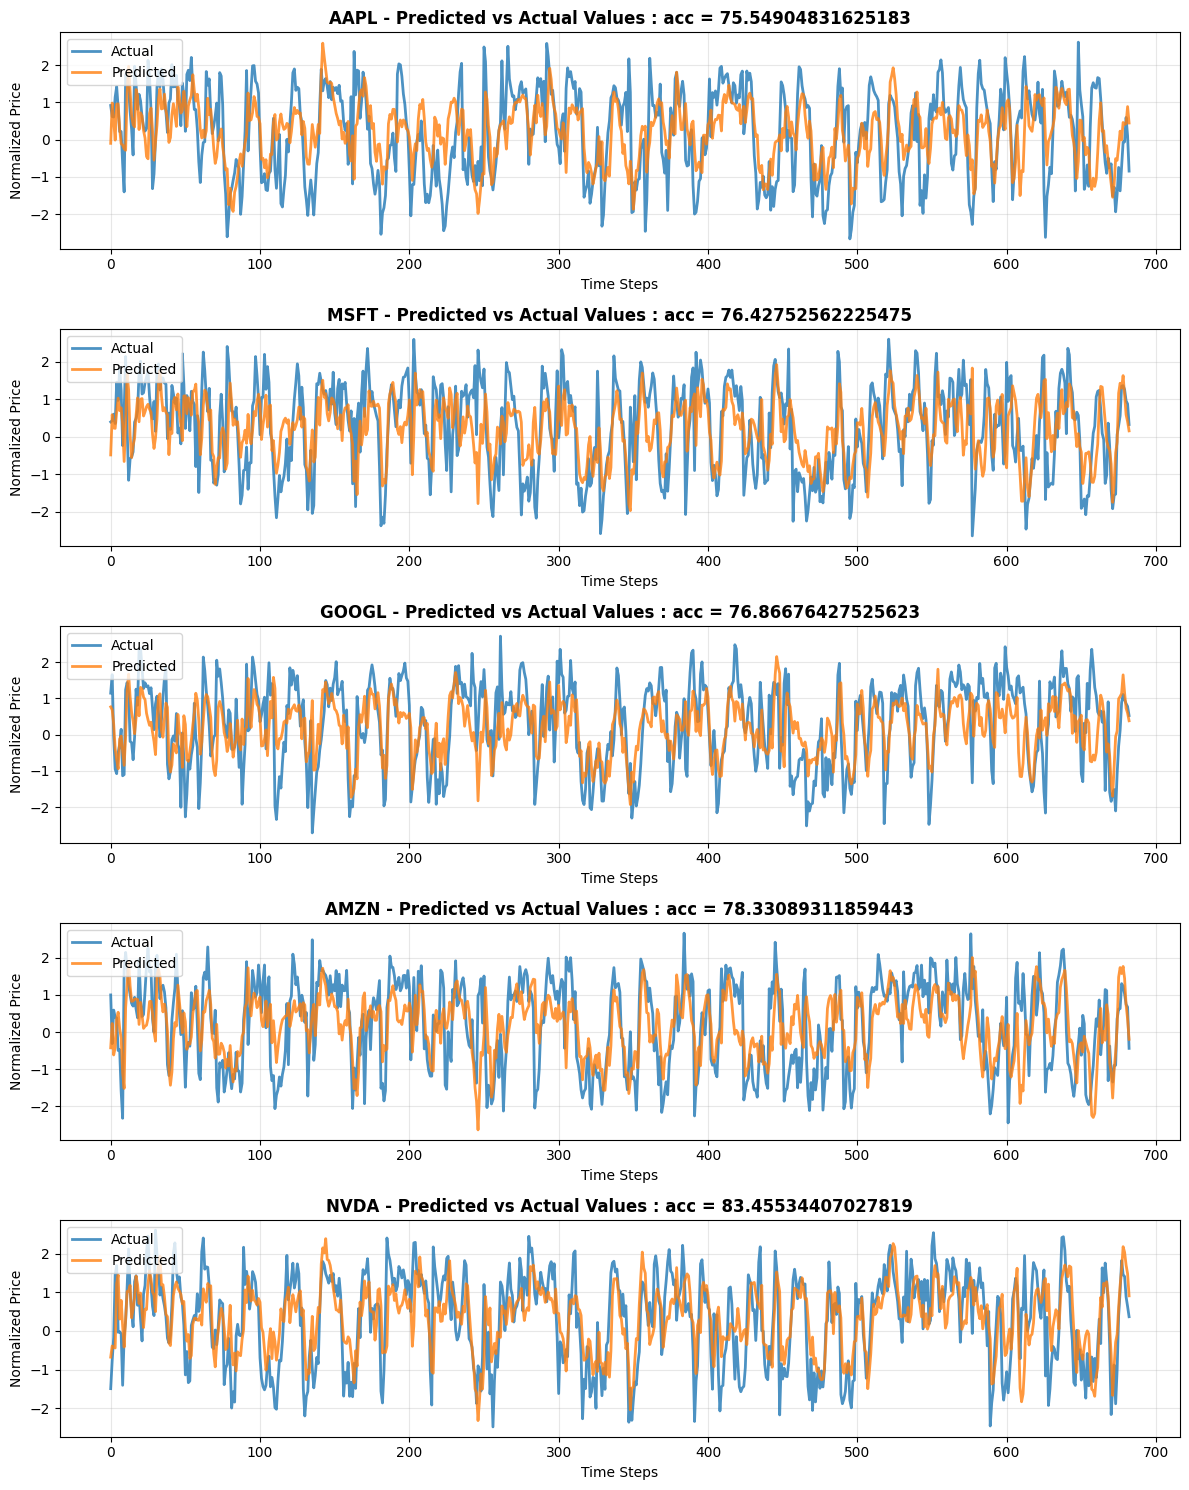

In [408]:


plot_predictions_by_asset(test_pred, test_y, sample_tickers)

In [409]:
# Use the existing inverse_transform method from RollingZScoreNorm class
denormalized_test_pred = norm_class.inverse_transform(test_pred, window=lookback)
denormalized_test_y = norm_class.inverse_transform(test_y, window=lookback)

print("Denormalized predictions shape:", denormalized_test_pred.shape)
print("Denormalized actuals shape:", denormalized_test_y.shape)
print("\nFirst 5 denormalized predictions:")
print(denormalized_test_pred[:5])




AttributeError: 'DataFrame' object has no attribute 'colums'

In [ ]:
plot_predictions_by_asset(denormalized_test_pred, denormalized_test_y, sample_tickers)